# Building Complex AI Algorithms from scratch 
> Ref. Taken from <a href="http://cs229.stanford.edu/#info">CS229</a> and <a href="https://www.fast.ai/">Fastai</a> Courses. 
- toc: true 
- badges: true
- comments: true
- sticky_rank: 1
- author: Rayan Kejriwal
- image: images/diagram.png
- categories: [AI, Algorithms]

In [2]:
#hide
import torch
from torch import tensor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn.functional as F

# Lets talk about basic SGD in Pytorch 

In [2]:
def f(x): return x**2

In [6]:
# The parameter we need gradient for (weights which we need to update) -> we do requires_grad_()
xt = tensor(3.).requires_grad_()

Notice the special method `requires_grad_`? That's the magical incantation we use to tell PyTorch that we want to calculate gradients with respect to that variable at that value. It is essentially tagging the variable, so PyTorch will remember to keep track of how to compute gradients of the other, direct calculations on it that you will ask for.

In [17]:
yt = f(xt)

In [18]:
yt.backward()

The "backward" here refers to *backpropagation*, which is the name given to the process of calculating the derivative of each layer (in case of neural network).

In [19]:
xt.grad #(This grad arrtibute accumulates the gradient at the variable x and keeps adding them consecutively unless you zero out the recent grads by using **zero_grad** arrtibute.

tensor(6.)

In [16]:
xt.grad.zero_()

tensor(0.)

Now we can try with a vector : 

In [42]:
def f(x): return (x**2).sum()

In [43]:
def calc_grad(x,f):
  y=f(x)
  y.backward()
  print(x.grad)
  x.grad.zero_()

In [46]:
calc_grad(tensor([3.,4.,5.],requires_grad=True),f)

tensor([ 6.,  8., 10.])


As we can see, we got right results! One thing is to notice that tensors always accept floating points and the `grad can be implicitly created only for scalar outputs` therefore the `function f` must return a scalar thats why we did apply `.sum()`. 

Lets Take Another End-To-End Example of SGD

In [ ]:
#Defining our X variable -> time
time = torch.arange(20).float()
time

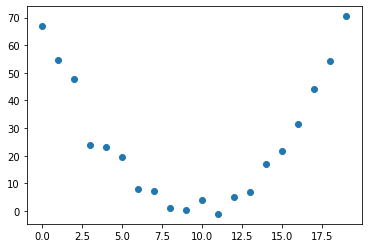

In [63]:
# Defining our Y variable -> speed
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

In [48]:
def f(t, params):
  a,b,c=params
  return a*(t**2) + b*t + c

In [57]:
# Initiate Parameters
params = torch.randn(3).requires_grad_()
orig_params = params.clone() # Clone method will also copy autograd func.
orig_params

tensor([0.2193, 0.4842, 0.5411], grad_fn=<CloneBackward>)

In [58]:
# Now calculate preds
preds = f(time, params)

Let's create a little function to see how close our predictions are to our targets, and take a look:

In [72]:
def show_preds(preds, ax=None):
  if ax is None: ax=plt.subplots()[1]
  ax.scatter(time, speed)
  ax.scatter(time, (preds).detach().numpy(), color='red')
  ax.set_ylim(-300,100)

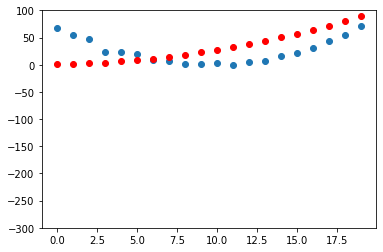

In [73]:
show_preds(preds)

In [79]:
# We calculate the loss as follows:
loss = F.mse_loss(preds,speed)
loss

tensor(1017.8171, grad_fn=<MseLossBackward>)

Our Goal is to now improve this loss. The next step is to calculate the gradients.


In [80]:
loss.backward() # .backward() method is applied on the variable of which we want to calculate gradient. 
params.grad # gradient is calculated w.r.t params ->(a,b,c)

tensor([6582.9756,  437.4914,   13.7502])

In [81]:
# We can use these gradients to improve our parameters. We'll need to pick a learning rate
lr = 1e-5
params.grad * lr

tensor([0.0658, 0.0044, 0.0001])

In [82]:
# Stepping/Updating the weights/parameters
params.data -= params.grad.data*lr

In [83]:
# Setting the gradients to zero after 1 step so that they may not accumulate
params.grad = None

> Understanding this bit depends on remembering recent history. To calculate the gradients we call backward on the loss. But this loss was itself calculated by mse, which in turn took preds as an input, which was calculated using f taking as an input params, which was the object on which we originally called required_grads_—which is the original call that now allows us to call backward on loss. This chain of function calls represents the mathematical composition of functions, which enables PyTorch to use calculus's chain rule under the hood to calculate these gradients.

In [87]:
# Lets see if the loss has imporved after updating our params(a,b,c):
preds = f(time,params)
F.mse_loss(preds,speed)

tensor(705.5072, grad_fn=<MseLossBackward>)

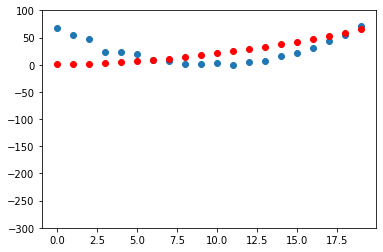

In [88]:
show_preds(preds)

In [107]:
#Now collecting everything altogether in a function :
def apply_step(params,prn=True):
  preds = f(time,params)
  loss = F.mse_loss(preds,speed)
  loss.backward()
  params.data -= params.grad.data*1e-5
  params.grad = None
  if prn: print(loss.item()) #In this case our Metric is same as loss function 
  return preds

In [95]:
for i in range(10): apply_step(params)

646.4049072265625
642.8947143554688
634.5457153320312
632.962158203125
632.65869140625
632.5977172851562
632.5823974609375
632.5758666992188
632.5709228515625
632.5662841796875


We just decided to stop after 10 epochs arbitrarily. In practice, we would watch the training and validation losses and our metrics to decide when to stop

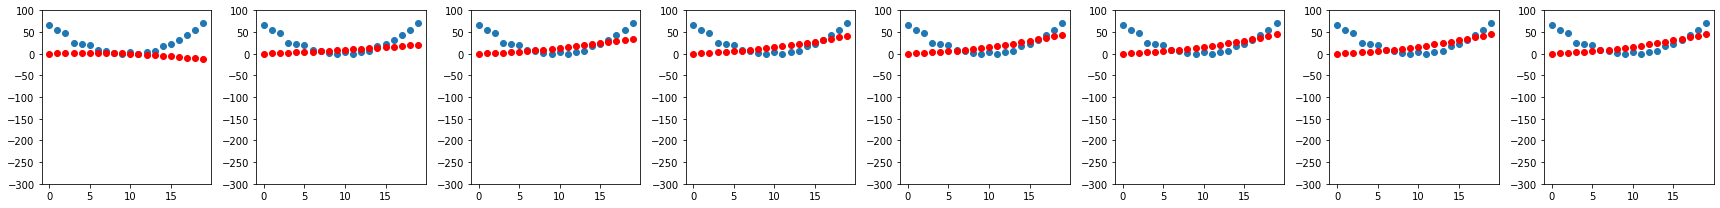

In [106]:
params = torch.randn(3).requires_grad_()
_,axs = plt.subplots(1,8,figsize=(24,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

In 8 epochs, from left to right we can see that how our predictions are improving with a constant lr=1e-5

# 2) A simple Logistic Regression Class

In [12]:
class LogisticRegression():
  def __init__(self) : pass  
   
  def get_params(self,size) -> torch.LongTensor: return torch.randn(size).requires_grad_()

  def sigmoid(self,x) : return 1/(1+torch.exp(-x))

  def mse_loss(self,predictions,targets) -> torch.LongTensor: return torch.where(targets==1, 1-predictions, predictions).mean() 
  
  def fit(self,x,y,epochs,bs,lr,trim=False):
    dset = list(zip(x,y))
    n_batches = int(len(dset)/bs)
    if (trim==False) : n_mini_batches= n_batches+int(len(dset)%bs)
    weights = self.get_params(x.shape[1])
    bias = self.get_params(1)
    for e in range(epochs):
      for i in range(n_mini_batches):
        if(i == n_mini_batches-1) : xb = x[i*bs:]
        else : xb = x[i*bs:(i+1)*bs]
        preds = self.sigmoid(x@weights + bias)
        loss = self.mse_loss(preds,y)
        loss.backward()
        weights.data -= weights.grad.data*lr  
        bias.data -= bias.grad.data*lr  
        weights.grad = None
        bias.grad = None
      print(f"Epoch_{e}_accuracy = ",((preds>=0.5)==y).float().mean().item())


  def predict(self,x):
    return x*weights + bias


#3) Experimenting with MNIST :




In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastai.vision.all import *
from fastbook import *
matplotlib.rc('image', cmap='Greys')

     |████████████████████████████████| 720 kB 6.7 MB/s 
     |████████████████████████████████| 1.2 MB 44.6 MB/s 
     |████████████████████████████████| 186 kB 60.5 MB/s 
     |████████████████████████████████| 46 kB 3.4 MB/s 
     |████████████████████████████████| 56 kB 3.1 MB/s 
     |████████████████████████████████| 51 kB 212 kB/s 
Mounted at /content/gdrive


In [5]:
#hide
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path

In [6]:
#hide
path.ls()

(#3) [Path('train'),Path('valid'),Path('labels.csv')]

In [7]:
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

In [8]:
(path/'valid').ls()

(#2) [Path('valid/3'),Path('valid/7')]

In [9]:
#hide
train_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'train'/'3').ls()])
train_3_tens = train_3_tens.float()/255
train_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'train'/'7').ls()])
train_7_tens = train_7_tens.float()/255

In [11]:
#hide
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255

In [12]:
train_x = torch.cat([train_3_tens, train_7_tens]).view(-1, 28*28)
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
train_y = tensor([1]*len(train_3_tens) + [0]*len(train_7_tens)).unsqueeze(1)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)

In [10]:
train_x.shape, valid_x.shape

(torch.Size([12396, 784]), torch.Size([2038, 784]))

In [13]:
m = LogisticRegression()

In [14]:
m.fit(x=train_x,y=train_y,bs=100,lr=1e-5,epochs=10)

Epoch_0_accuracy =  0.5040026903152466
Epoch_1_accuracy =  0.5040026903152466
Epoch_2_accuracy =  0.5040026903152466
Epoch_3_accuracy =  0.5040026903152466
Epoch_4_accuracy =  0.5040026903152466
Epoch_5_accuracy =  0.5040026903152466
Epoch_6_accuracy =  0.5040026903152466
Epoch_7_accuracy =  0.5040026903152466
Epoch_8_accuracy =  0.5040026903152466
Epoch_9_accuracy =  0.5040026903152466


Putting it Altogether - Using Fastai Dataloaders !


In [13]:
train_dset = list(zip(train_x,train_y))
valid_dset = list(zip(valid_x,valid_y))

 > Note: Now we will use fastai Dataloaders for to Load Data in mini-batches rathar than a single row in SGD. Just To say 
 * Dataset - A list of tuples each tuple of form -> $(x_i,y_i)$
 * DataLoader - An Iterable/List of Minibatches where each minibatch is of the form $tuple(tensor(x_1,x_2,...,x_b), (y_1,y_2,...,y_b))$.

